In [ ]:
%conda install -c huggingface transformers

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model.to(torch.device("cuda"))

c:\Users\yitao\.conda\envs\clipseg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [3]:
from PIL import Image
from torch import nn

In [4]:
from myutils.img_loader import get_img_by_id
from myutils.processors import toBinary


def getPred(id: int, prompts=["bee", "background"]):
    input_image = get_img_by_id(id)
    inputs = processor(
        text=prompts,
        images=[input_image] * len(prompts),
        padding="max_length",
        return_tensors="pt",
    )
    inputs = inputs.to(torch.device("cuda"))

    with torch.no_grad():
        outputs = model(**inputs)

    # print(outputs.logits.shape)

    preds = nn.functional.interpolate(
        outputs.logits.unsqueeze(1),
        size=(input_image.size[1], input_image.size[0]),
        mode="bilinear",
    )
    return preds

In [5]:
preds = getPred(5)

In [6]:
bi_preds = [toBinary(preds[i][0], 0.3) for i in range(len(preds))]

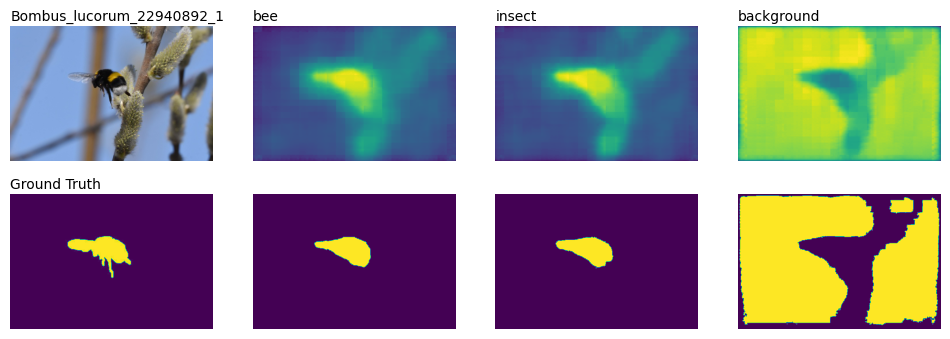

In [8]:
from matplotlib import pyplot as plt
from myutils.img_loader import get_imgName

id = 2
prompts = ["bee", "insect", "background"]
input_image = get_img_by_id(id)
ground_truth = get_img_by_id(id, "./dataset/masks/gt/")
preds = getPred(id, prompts)
bi_preds = [toBinary(preds[i][0], 0.8) for i in range(len(preds))]

_, ax = plt.subplots(2, len(prompts) + 1, figsize=(3 * (len(prompts) + 1), 4))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
ax[0][0].text(0, -15, get_imgName(id))
[ax[0][i + 1].imshow(preds[i][0].cpu()) for i in range(len(prompts))]
[ax[0][i + 1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]
ax[1][0].imshow(ground_truth)
ax[1][0].text(0, -15, "Ground Truth")
[ax[1][i + 1].imshow(bi_preds[i].cpu()) for i in range(len(prompts))]

In [39]:
from myutils.img_loader import get_imgNames
from myutils.processors import toBinary, savePic
import os

img_names = get_imgNames()


def saveMask(t: float):
    path = "./dataset/masks/clipseg/" + str(t) + "/"
    output_dir = os.path.exists(path)
    if not output_dir:
        os.mkdir(path)

    for i in range(len(img_names)):
        preds = getPred(i + 1)
        savePic(toBinary(preds[0][0].cpu(), t), path, img_names[i] + ".png", True)
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

In [51]:
saveMask(0.8)
saveMask(0.83)
saveMask(0.85)
saveMask(0.77)
saveMask(0.75)

FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726


In [52]:
saveMask(0.81)
saveMask(0.82)
saveMask(0.78)
saveMask(0.79)
saveMask(0.7)
saveMask(0.9)

FINISHED! 	726/726
FINISHED! 	726/726


In [10]:
import os


def convertPNG(id: int, output_dir: str, t: float):
    img_name = img_names[id - 1]
    output_path = output_dir + img_name

    if not os.path.isfile(output_path):
        preds = getPred(id)
        mask = toBinary(preds[0][0], t)
        png = Image.new("1", (mask.shape[1], mask.shape[0]))
        pixels = png.load()
        for i in range(png.size[0]):
            for j in range(png.size[1]):
                pixels[i, j] = int(mask[j][i])

        png.save(output_path)


def saveMask(t: float):
    path = "./dataset/masks/clipseg/" + str(t) + "/"
    output_dir = os.path.exists(path)
    if not output_dir:
        os.mkdir(path)

    for i in range(len(img_names)):
        convertPNG(i + 1, path, t)
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

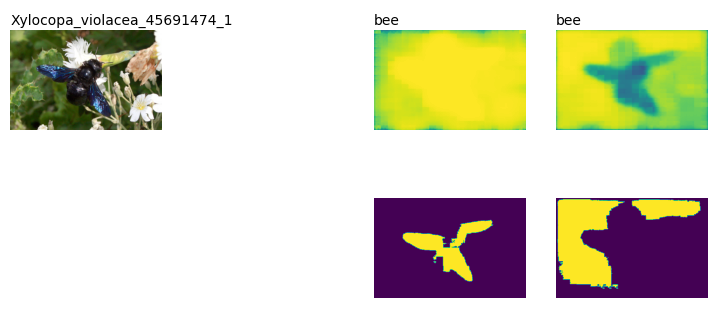

In [31]:
from matplotlib import pyplot as plt
from myutils.img_loader import get_imgName

id = 501
prompts = ["bee", "bee"]
input_image = get_img_by_id(id)
preds = getPred(id).cpu()
bi_preds = [toBinary(preds[i][0], 0.85) for i in range(len(preds))]

_, ax = plt.subplots(2, len(prompts) + 2, figsize=(3 * (len(prompts) + 1), 4))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
ax[0][0].text(0, -15, get_imgName(id))
[ax[0][i + 2].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[0][i + 2].text(0, -15, prompt) for i, prompt in enumerate(prompts)]
[ax[1][i + 2].imshow(bi_preds[i]) for i in range(len(prompts))]

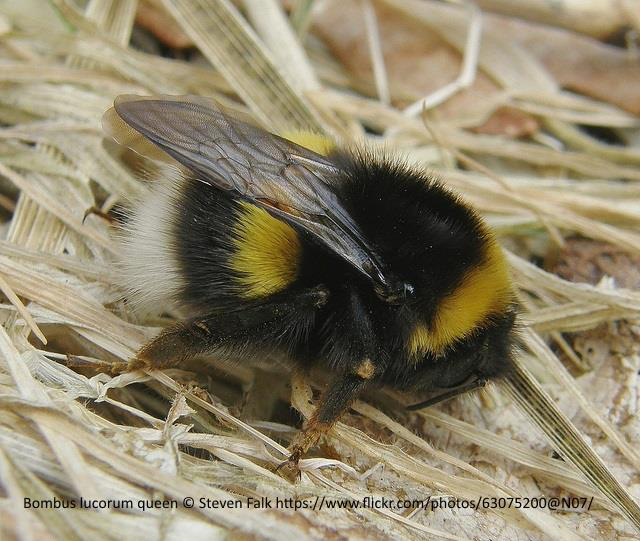

In [13]:
import requests

url = "https://ws.biodiversityireland.ie/api/taxonImage/916"
prompt = Image.open(requests.get(url, stream=True).raw)
prompt

In [14]:
encoded_image = processor(images=[input_image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(0).unsqueeze(1),
    size=(input_image.size[1], input_image.size[0]),
    mode="bilinear",
)

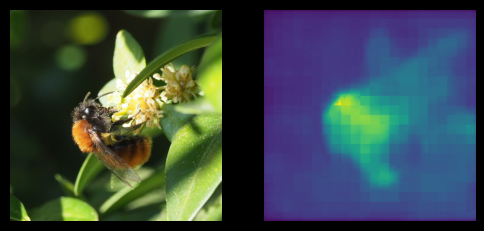

In [15]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(torch.sigmoid(preds[0][0]))

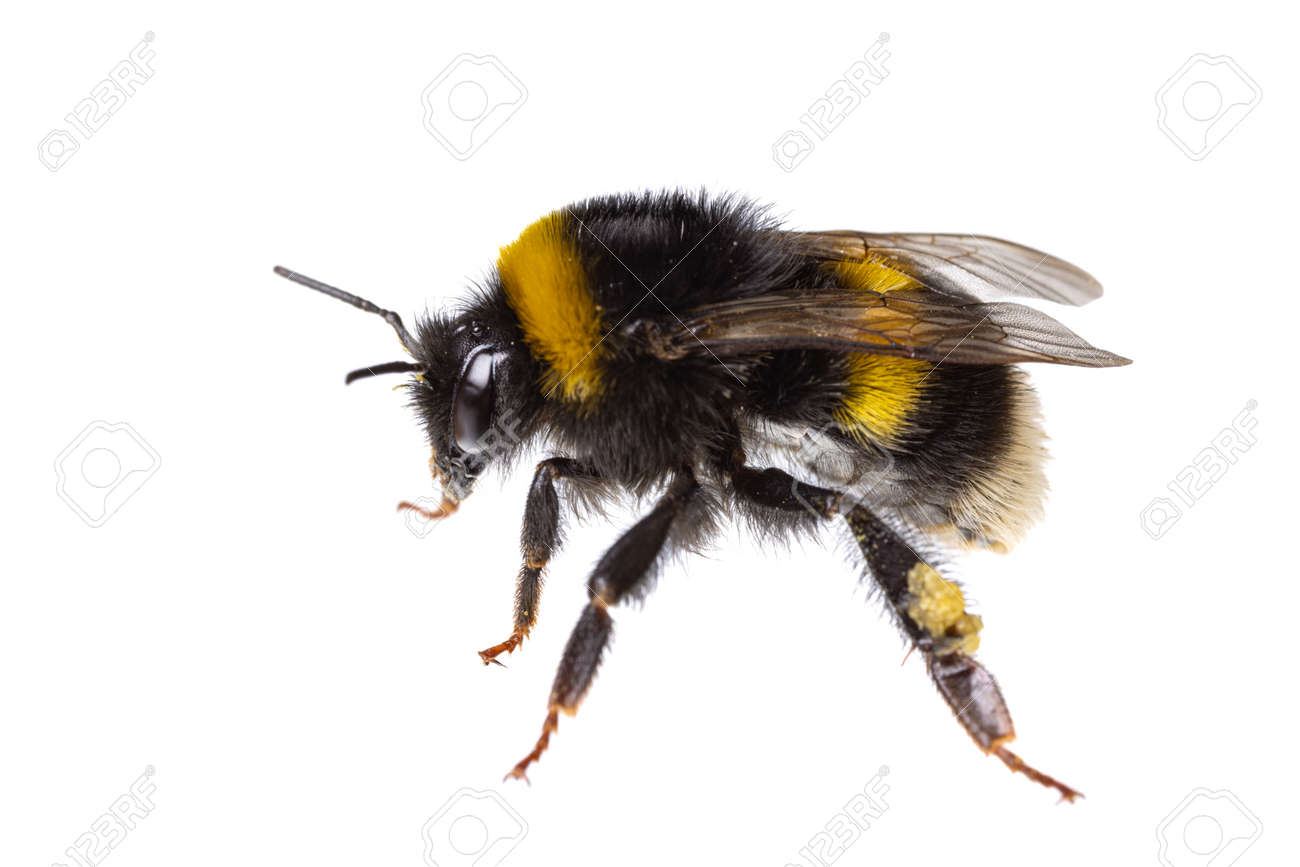

In [16]:
url_alt = "https://previews.123rf.com/images/unpict/unpict2205/unpict220500038/185647275-insekten-europas-bienen-seitenansicht-makro-der-weiblichen-hummel-komplexe-bombus-lucorum.jpg"
alternative_prompt = Image.open(requests.get(url_alt, stream=True).raw)
alternative_prompt

In [17]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)

preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(0).unsqueeze(1),
    size=(input_image.size[1], input_image.size[0]),
    mode="bilinear",
)

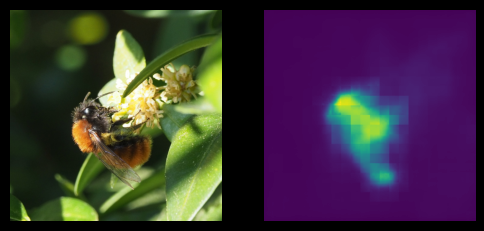

In [18]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(torch.sigmoid(preds[0][0]))